In [1]:
import os
import sys
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, GPT2Model, GPT2LMHeadModel
from transformers.generation.configuration_utils import GenerationConfig

sys.path.append(os.path.abspath('../'))
from llm_pretrain import Speaker, Listener

/home/vateseifelfrej/anaconda3/envs/maddpg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# free up GPU memory
torch.cuda.empty_cache()

# params
n_embed = 768
batch_size = 1

# RL training params
lr = 7e-4
n_episodes = 1000
n_landmarks = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

# IO dimensions
speaker_in = 3
speaker_out = 5
listener_in = n_landmarks*2
listener_out = 2

# speaker generation params
num_beams = 5
early_stopping = True
no_repeat_ngram_size = 1
do_sample = False
temperature = 0.9
top_k = 50
top_p = 0.9
max_length = speaker_out

# directory with model weights
model_dir = os.path.join(os.path.abspath('../'), 'results/', "GPT2", "16")
assert os.path.exists(model_dir), f'{model_dir} doesnt exist'
weights = torch.load(os.path.join(model_dir, 'model.pt'), map_location=torch.device(device))

In [8]:
# landamrk colors
landmarks_c = sns.color_palette(n_colors=n_landmarks)
landmarks_c = torch.tensor(landmarks_c).unsqueeze(1)
# landmarks positions
landmarks_p = ((torch.rand((batch_size, 2*n_landmarks)) - 0.5) * 2)
landmarks_xy = landmarks_p.reshape(batch_size, n_landmarks, 2)

In [4]:
speaker = Speaker()
listener = Listener()

speaker.embed_ln.load_state_dict(weights['speaker']['embed_ln'])
speaker.embed_obs.load_state_dict(weights['speaker']['embed_obs'])

listener.embed_ln.load_state_dict(weights['listener']['embed_ln'])
listener.embed_obs.load_state_dict(weights['listener']['embed_obs'])
listener.predict_action.load_state_dict(weights['listener']['predict_action'])

speaker.eval()
listener.eval()
1

1

In [10]:
# letters used for which landmark color by speaker
msgLandmarkMap = {listener.tokenizer.decode(speaker(l.unsqueeze(0))[0], skip_special_tokens=True): [] for l in landmarks_c}
for i in range(n_landmarks):
  msg = listener.tokenizer.decode(speaker(landmarks_c[i].unsqueeze(0))[0], skip_special_tokens=True)
  msgLandmarkMap[msg].append(i)

def computeCentroid(msg):
  """Given a message (the argmax) it checks which other landmarks use the same msg and computes the centroid and the mean color"""
  xy = torch.mean(landmarks_xy[:,msgLandmarkMap[msg]], dim=1)
  c = torch.mean(landmarks_c[msgLandmarkMap[msg]], dim=0)
  return xy, c

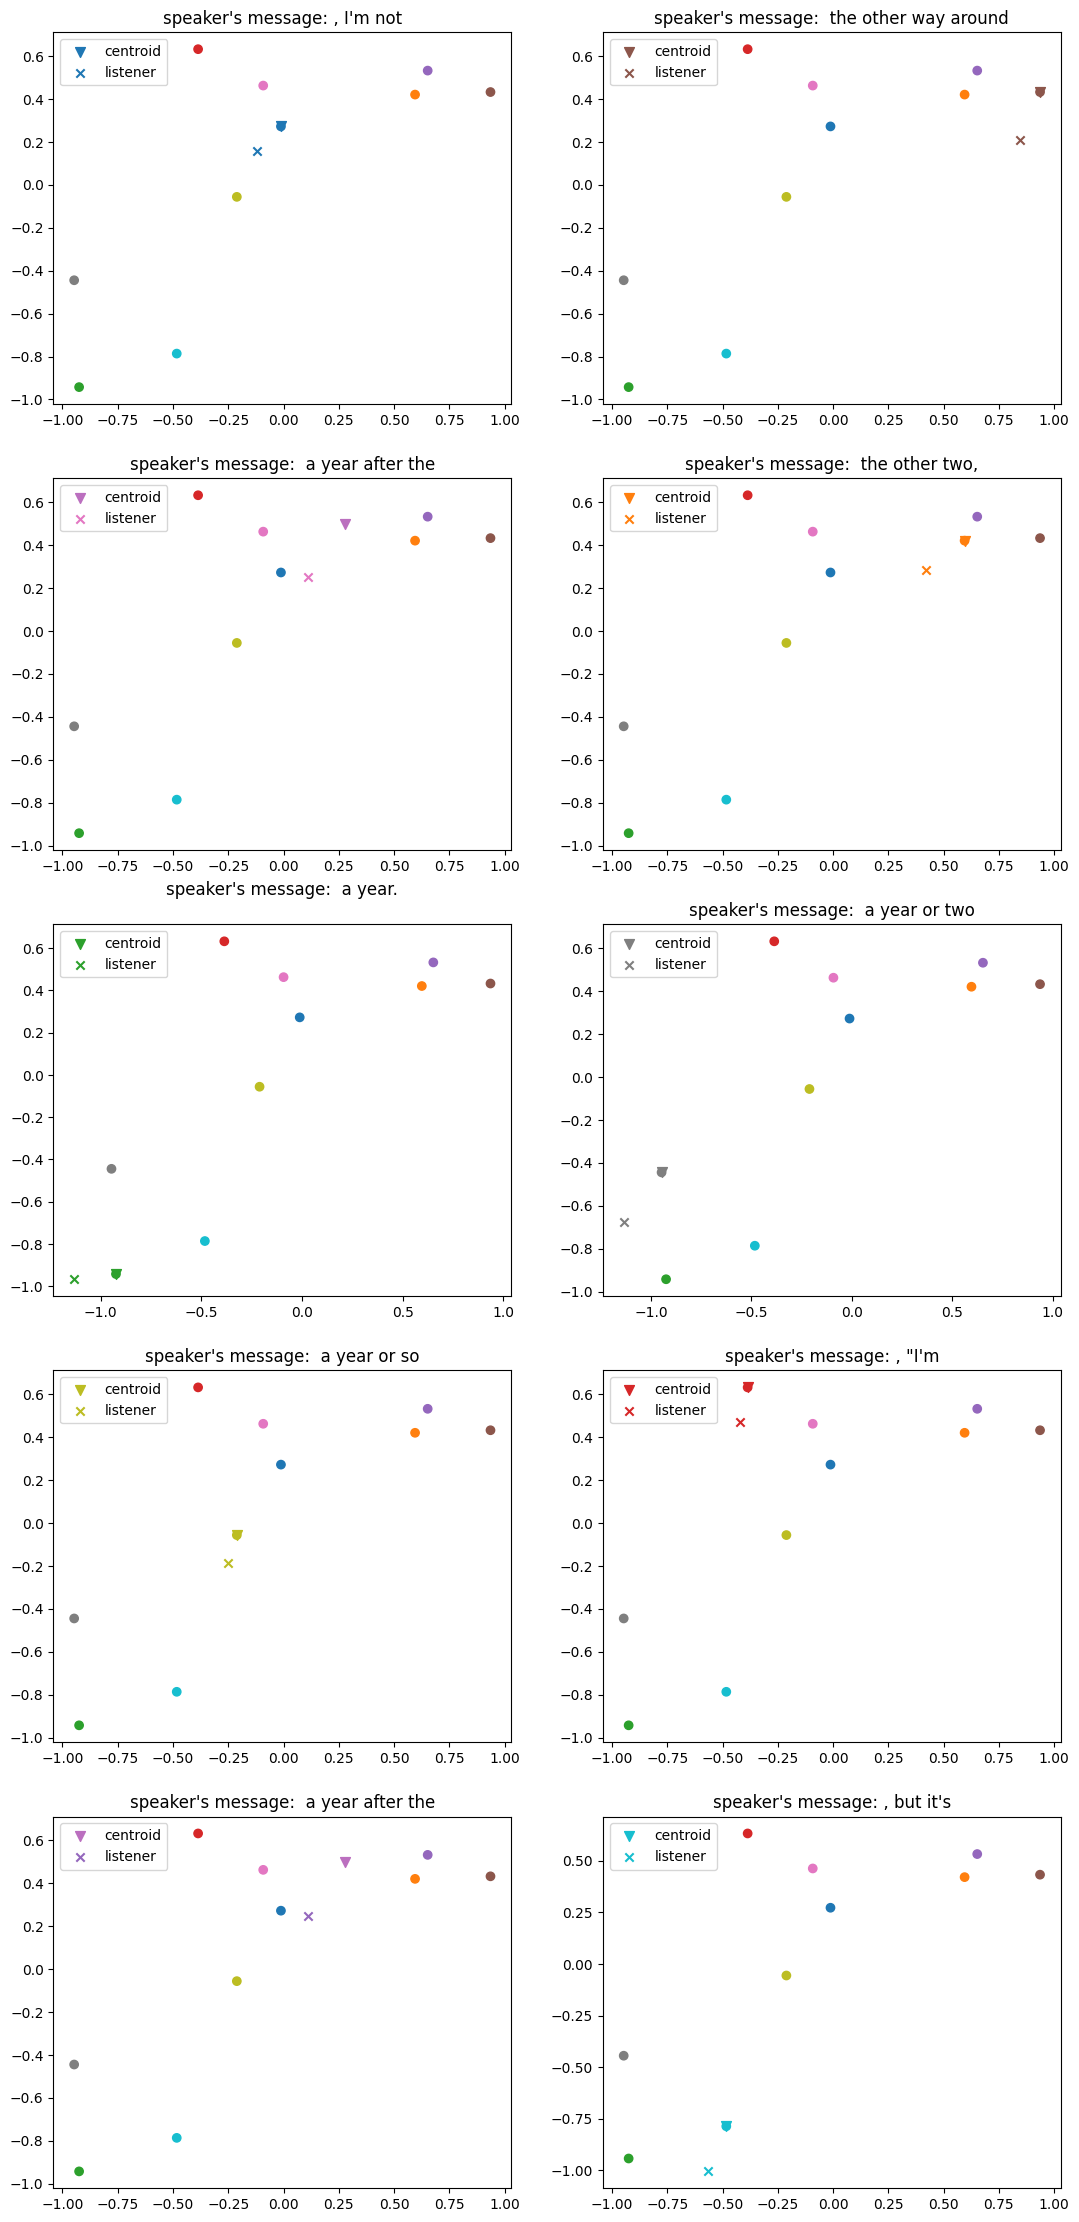

In [11]:
fig, ax = plt.subplots(nrows=int(n_landmarks/2), ncols=2, figsize=(13, 28))

for i in range(n_landmarks):
  # speaker input
  #goal_landmarks = (landmarks_c.repeat(batch_size, 1, 1)[ids]).to(device)
  #print(goal_landmarks.shape)
  # messages from speaker
  msg = speaker(landmarks_c[i].unsqueeze(0))
  # compute action from lisener
  action = listener(landmarks_p, msg)
  # string message
  msg_string = listener.tokenizer.decode(msg[0], skip_special_tokens=True)
  # compute centroid of chosen message
  centroid_xy, centroid_c = computeCentroid(msg_string)

  #plt.figure()
  #plt.scatter([l for i, l in enumerate(landmarks_p[0]) if i%2==0], [l for i, l in enumerate(landmarks_p[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
  #plt.scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[i])
  #plt.title(f"speaker's message: {msg_string}")

  ax[i%int(n_landmarks/2)][i%2].scatter([l for i, l in enumerate(landmarks_p[0]) if i%2==0], [l for i, l in enumerate(landmarks_p[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
  ax[i%int(n_landmarks/2)][i%2].scatter(centroid_xy[0, 0], centroid_xy[0, 1], marker='v', s=50, c=centroid_c, label='centroid')
  ax[i%int(n_landmarks/2)][i%2].scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[i], label='listener')
  ax[i%int(n_landmarks/2)][i%2].legend(loc='best')
  ax[i%int(n_landmarks/2)][i%2].set_title(f"speaker's message: {msg_string}")